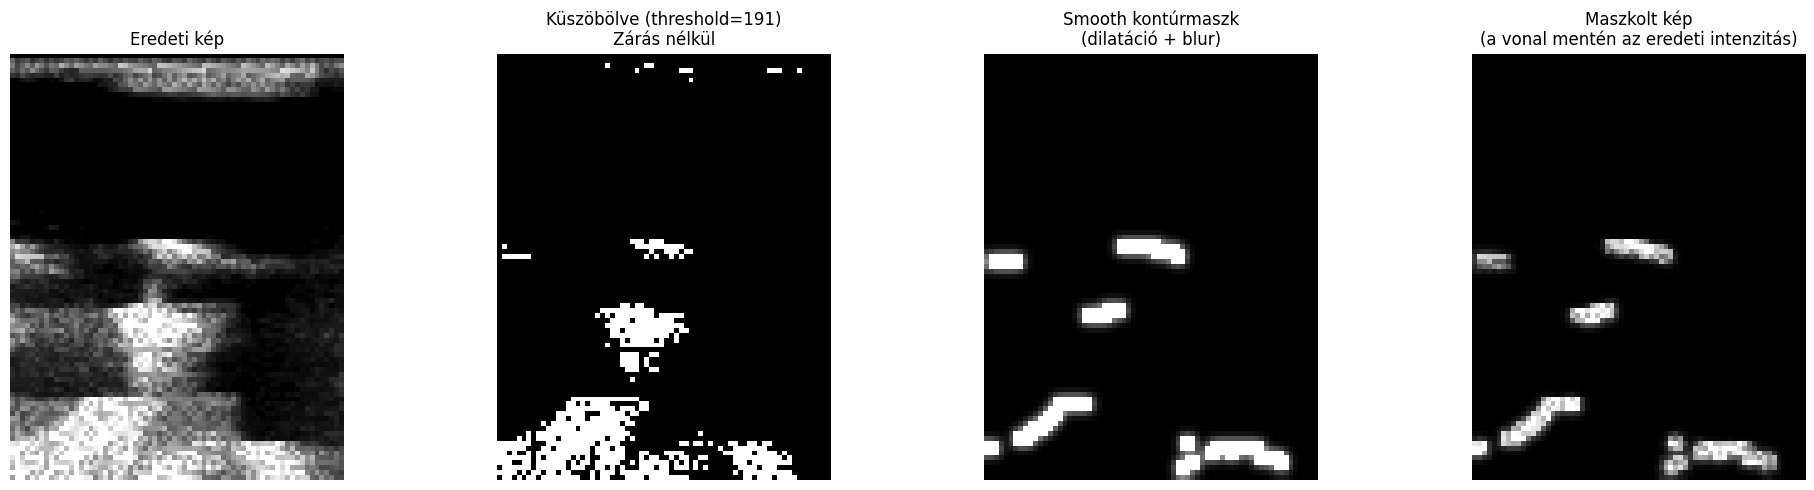

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def remove_top_noise_and_keep_first_white(image_path,
                                          top_percent=0.90,
                                          top_margin=5,
                                          apply_closing=True):
    """
    top_percent:   A hisztogram hányadik százalékánál húzunk küszöböt
                   (pl. 0.90 = 90%, azaz a felső 10% intenzitás fehérré válik).
    top_margin:    Ekkora (pixeles) sávot tekintünk 'felső zajnak'.
                   Ha a komponens ennél lejjebb indul, nem töröljük.
    apply_closing: Ha True, morfológiai zárást alkalmazunk,
                   hogy összefüggőbbé tegyük a fehér foltokat.
    """

    # 1) Kép betöltése szürkeárnyalatosként
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        raise IOError(f"Nem sikerült betölteni a képet: {image_path}")

    # 2) Hisztogram és kumulatív eloszlás számítása
    hist, bins = np.histogram(image.flatten(), bins=256, range=[0, 256])
    cdf = hist.cumsum()
    cdf_normalized = cdf / float(cdf[-1])

    # Kiszámoljuk azt az intenzitás értéket, ahol elérjük a top_percent-et
    threshold_idx = np.where(cdf_normalized >= top_percent)[0]
    if len(threshold_idx) == 0:
        threshold_value = 255
    else:
        threshold_value = threshold_idx[0]

    # 3) Bináris maszk létrehozása
    mask = (image >= threshold_value).astype(np.uint8) * 255

    # 4) Morfológiai zárás (opcionális)
    if apply_closing:
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2,2))
        mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

    # 5) Connected Components a felső zaj törléséhez
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(mask, connectivity=8)

    # 6) A kép tetejéről induló komponensek eltávolítása
    for i in range(1, num_labels):
        x, y, w, h, area = stats[i]
        if y < top_margin:
            mask[labels == i] = 0

    # 7) "Csak az első fehér pixel maradjon oszloponként"
    height, width = mask.shape
    contour_mask = np.zeros_like(mask)
    for col in range(width):
        col_pixels = mask[:, col]
        white_indices = np.where(col_pixels == 255)[0]
        if len(white_indices) > 0:
            topmost = white_indices[0]
            contour_mask[topmost, col] = 255

    # 8) Dilatáció a kontúr vastagításához
    dilation_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
    dilated_mask = cv2.dilate(contour_mask, dilation_kernel, iterations=1)

    # 9) Gaussian blur alkalmazása a dilatált maszkra,
    #    hogy puha átmenetet kapjunk a bináris értékek között.
    smooth_mask = cv2.GaussianBlur(dilated_mask, (5,5), 0)
    # Biztosítjuk, hogy azon helyeken, ahol a dilatált maszk 255 volt,
    # a sima maszk is maradjon 255, így a vonal mentén az eredeti intenzitás nem csökken.
    smooth_mask[dilated_mask == 255] = 255

    # 10) Az eredeti kép maszkolása a smooth_mask értékével.
    #     A smooth_mask-et normalizáljuk 0-1 közé, majd megszorozzuk az eredeti képpel.
    smooth_mask_normalized = smooth_mask.astype(np.float32) / 255.0
    masked_image = (image.astype(np.float32) * smooth_mask_normalized).astype(np.uint8)

    # Visszatérünk az eredeti képpel, a küszöbértékkel, a sima kontúrmaszkkal,
    # és a maszkolt képpel.
    return image, threshold_value, smooth_mask, masked_image

if __name__ == "__main__":
    #image_path = "transformation_curved_flat.test.png"
    #image_path = "sample_curved_cropped_01.png"
    image_path = "transformation_curved_flat_whole_test.png"

    # Paraméterek
    top_percent  = 0.90
    top_margin   = 5
    apply_closing = True

    # Feldolgozás
    original, thresh_val, final_mask, masked_image = remove_top_noise_and_keep_first_white(
        image_path,
        top_percent=top_percent,
        top_margin=top_margin,
        apply_closing=apply_closing
    )

    # Készítsünk egy maszkot a küszöböléshez morfológiai zárás nélkül (összehasonlításképpen)
    hist, bins = np.histogram(original.flatten(), bins=256, range=[0, 256])
    cdf = hist.cumsum()
    cdf_normalized = cdf / float(cdf[-1])
    threshold_idx = np.where(cdf_normalized >= top_percent)[0]
    if len(threshold_idx) == 0:
        raw_thresh = 255
    else:
        raw_thresh = threshold_idx[0]

    raw_mask = (original >= raw_thresh).astype(np.uint8) * 255

    fig, axs = plt.subplots(1, 4, figsize=(20, 5))

    # 1. Eredeti kép
    axs[0].imshow(original, cmap="gray")
    axs[0].axis("off")
    axs[0].set_title("Eredeti kép")

    # 2. Bináris maszk (zárás nélkül)
    axs[1].imshow(raw_mask, cmap="gray")
    axs[1].axis("off")
    axs[1].set_title(f"Küszöbölve (threshold={raw_thresh})\nZárás nélkül")

    # 3. Simított kontúrmaszk (smooth_mask)
    axs[2].imshow(final_mask, cmap="gray")
    axs[2].axis("off")
    axs[2].set_title("Smooth kontúrmaszk\n(dilatáció + blur)")

    # 4. Maszkolt kép (az eredeti intensitások megmaradnak a kontúr mentén)
    axs[3].imshow(masked_image, cmap="gray")
    axs[3].axis("off")
    axs[3].set_title("Maszkolt kép\n(a vonal mentén az eredeti intenzitás)")

    plt.tight_layout()
    plt.show()
